In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset using Pandas
data = pd.read_csv('data_supervised.csv')
data['Article'] = data['Article'].apply(lambda x: str(x))
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


## Text preprocessing

In [2]:
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
filename = 'tagalog_stop_words.txt'
with open(filename, 'r') as file:
    stop_words = file.read().splitlines()

with open(filename, 'r') as file:
    tagalog_words = file.read().splitlines()
stop_words.extend(tagalog_words)

# Tokenization and padding
max_words = 10000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['Article'])
X_train = tokenizer.texts_to_sequences(train_data['Article'])
X_test = tokenizer.texts_to_sequences(test_data['Article'])

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Convert your class labels into numerical values, typically using one-hot encoding or label encoding.
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(train_data['Category'])
Y_test = label_encoder.transform(test_data['Category'])
num_classes = len(label_encoder.classes_)

### Model architecture
---
Design your neural network architecture. A simple architecture for text classification is a combination of embedding layers, LSTM or GRU layers, and a dense output layer.

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dense(num_classes, activation='softmax'))

In [5]:
#Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
#train the model using training data
from keras.utils import to_categorical

Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_test = to_categorical(Y_test, num_classes=num_classes)

batch_size = 64
epochs = 10

model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, Y_test))

Epoch 1/10
75/75 [==============================] - 13s 155ms/step - loss: 1.5024 - accuracy: 0.3671 - val_loss: 1.1098 - val_accuracy: 0.5742
Epoch 2/10
75/75 [==============================] - 12s 157ms/step - loss: 1.0063 - accuracy: 0.5879 - val_loss: 0.8193 - val_accuracy: 0.6200
Epoch 3/10
75/75 [==============================] - 11s 152ms/step - loss: 0.6384 - accuracy: 0.7552 - val_loss: 0.6477 - val_accuracy: 0.7633
Epoch 4/10
75/75 [==============================] - 11s 147ms/step - loss: 0.4037 - accuracy: 0.8648 - val_loss: 0.5272 - val_accuracy: 0.8183
Epoch 5/10
75/75 [==============================] - 12s 154ms/step - loss: 0.1971 - accuracy: 0.9438 - val_loss: 0.5099 - val_accuracy: 0.8458
Epoch 6/10
75/75 [==============================] - 11s 153ms/step - loss: 0.1151 - accuracy: 0.9690 - val_loss: 0.5279 - val_accuracy: 0.8517
Epoch 7/10
75/75 [==============================] - 11s 151ms/step - loss: 0.0835 - accuracy: 0.9775 - val_loss: 0.5651 - val_accuracy: 0.8267

## Plotting

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

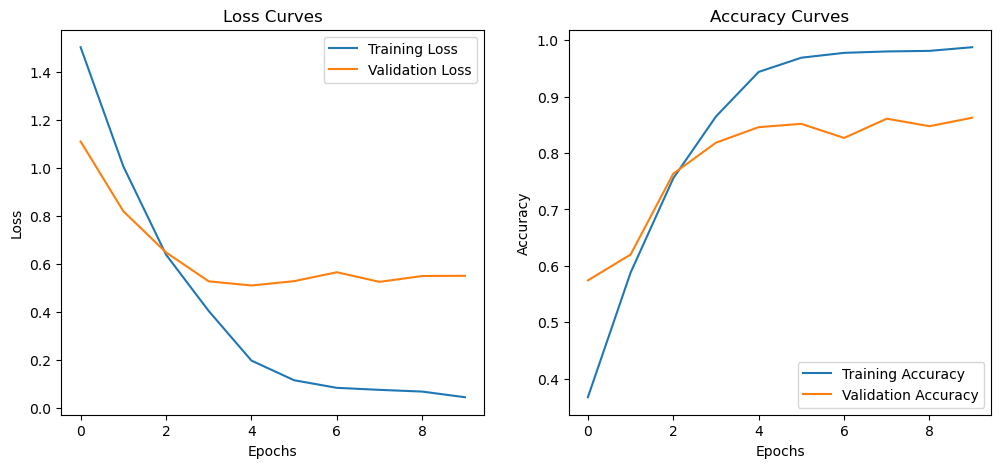

In [8]:
# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

38/38 [==============================] - 2s 26ms/step


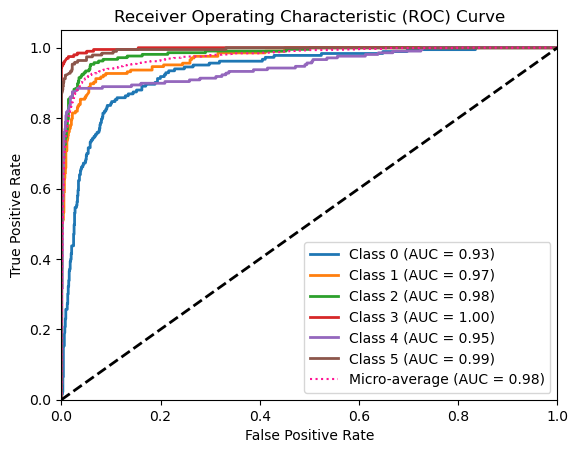

In [9]:
# Plot ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

Y_pred = model.predict(X_test)
Y_test = label_binarize(Y_test, classes=list(range(num_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
lw = 2
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Predicting new text

In [10]:
new_text = ["James yap, umiskor ng 40 points laban sa TNT"]
new_text_sequence = tokenizer.texts_to_sequences(new_text)
new_text_padded = pad_sequences(new_text_sequence, maxlen=max_sequence_length)

predictions = model.predict(new_text_padded)
predicted_label = label_encoder.inverse_transform([predictions.argmax()])
print(f"Predicted label: {predicted_label[0]}")

1/1 [==============================] - 0s 31ms/step
Predicted label: Palaro
